## Preliminares

### Problema

Necesidad de identicar las características asociadas a los alumnos que tienen un bajo desempeño en la escuela.

### Objetivos

* Generar un modelo que identifique aquellos alumnos que presentan un bajo desempeño académico.
* Abstraer en categorías latentes aspectos ambientales del alumno.

### Solución

* Se propone la implementación de un modelo predictivo de Regresión, en específico, de __Regresión Lineal Multiple__. 
* Para la busqueda de variables latentes de los aspectos ambientales, se propone la realización de un __Análisis Factorial__.

### Criterios de optimización y métricas de desempeño

Las métricas de desempeño a utilizar serán las asociadas a medir la capacidad del modelo de Regresión lineal multiple en predecir el vector objetivo de la muestra de evaluación. Concretamente, se utlizarán:

* Error cuadrático medio
* R2

Por otro lado, para el análisis factorial se utilizarán como medidas de optimización de factores y métricas del modelo:

* Eigenvalues de los factores
* Varianza acumulada de los factores

## Aspectos computacionales

### Librerías a utilizar

In [1]:
# Numpy: librería escencial para procesos matemáticos utilizados en data science
import numpy as np

# Pandas: librería para la creación y manipulación de estructura de datos
import pandas as pd

# Matplotlib: librería basada en Matlab, utilizada para realizar gráficos en 2D
import matplotlib.pyplot as plt

# Seaborn: librería avanzada para gráficos
import seaborn as sns

# Missingno: librería para visualizar de forma gráfica los valores perdidos
import missingno as msngo

#Statsmodels: librería para la implementación de modelos estadísticos
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Sklearn: Librería especializada en machine learning
# De sklearn se importa el objeto para implementar la regresión lineal
from sklearn.linear_model import LinearRegression

# Además, se importan las funciones para estandarizar las variables y dividir las muestras 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Y finalmente las métricas a utilizar definidas en la sección anterior 
from sklearn.metrics import mean_squared_error, r2_score

# Se importa y ejecuta librería de warnings para evitar avisos de deprecación
import warnings
warnings.filterwarnings("ignore")

# Importación de funciones creadas 
import funciones as fn

# Importación de librería de análisis factorial, incluyendo objeto y métricas
#import factor_analyzer as fact

# Para realizar validación cruzada de forma sucesiva el entrenamiento de modelo
from sklearn.model_selection import cross_val_score

#Versión extrema de validación cruzada, con tantos como modelos con (n-1) observaciones
from sklearn.model_selection import LeaveOneOut

#Para experimentar con modelos con atributos de forma polinomial
from sklearn.preprocessing import PolynomialFeatures

In [13]:
plt.style.use('ggplot')

### Preproceso y recodificación de los datos

* Se corregiran los valores de los datos perdidos, cambiandolos desde los strings 'nulidade', 'sem validade', 'zero' a 'NaN' de numpy.
* Se corregiran anomalías en las variables, especialmente por la presencia de caracterés "" en variables númericas.
* Se borarrá la columna 'Unnamed: 0'
* Se recodificarán todas las variables categóricas a dummies en forma binaria (0,1) por cada categoría.

## Descripción

### Importación de base y depuración

In [3]:
# Importación de base y correción de valores NaN
df = pd.read_csv('students.csv', sep='|', encoding='latin-1')

# Remover columna 'Unnamed: 0'
df = df.drop('Unnamed: 0', axis=1)

# Remoción de comillas en variables con anomalías
for i in ['age', 'goout', 'health']:
    df[i] = df[i].map(lambda x: np.where(len(x)<5, x[1:-1], x))

# Renombre de valores NaN 
df = df.replace(['nulidade', 'sem validade', 'zero', 'er'], 
                [np.nan, np.nan, np.nan, np.nan])

# Cambio de tipo de datos en columnas a formato númerico cuando sea posible
for colname, colserie in df.iteritems():
    df[colname] = pd.to_numeric(df[colname], errors='ignore')

In [4]:
# Muestra de la base
df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,NaN,U,GT3,A,4.0,4.0,at_home,teacher,...,4.0,3.0,4.0,1.0,1.0,3.0,6.0,5.0,6,6.0
1,GP,F,17.0,U,GT3,T,1.0,1.0,at_home,other,...,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5.0,5,6.0
2,GP,F,15.0,U,LE3,T,1.0,1.0,at_home,other,...,4.0,3.0,2.0,2.0,3.0,3.0,10.0,NaN,8,10.0
3,GP,F,15.0,U,GT3,T,4.0,2.0,health,services,...,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15.0,14,15.0
4,GP,F,NaN,U,GT3,T,3.0,3.0,other,other,...,4.0,3.0,2.0,1.0,2.0,5.0,4.0,6.0,10,10.0


### Datos perdidos

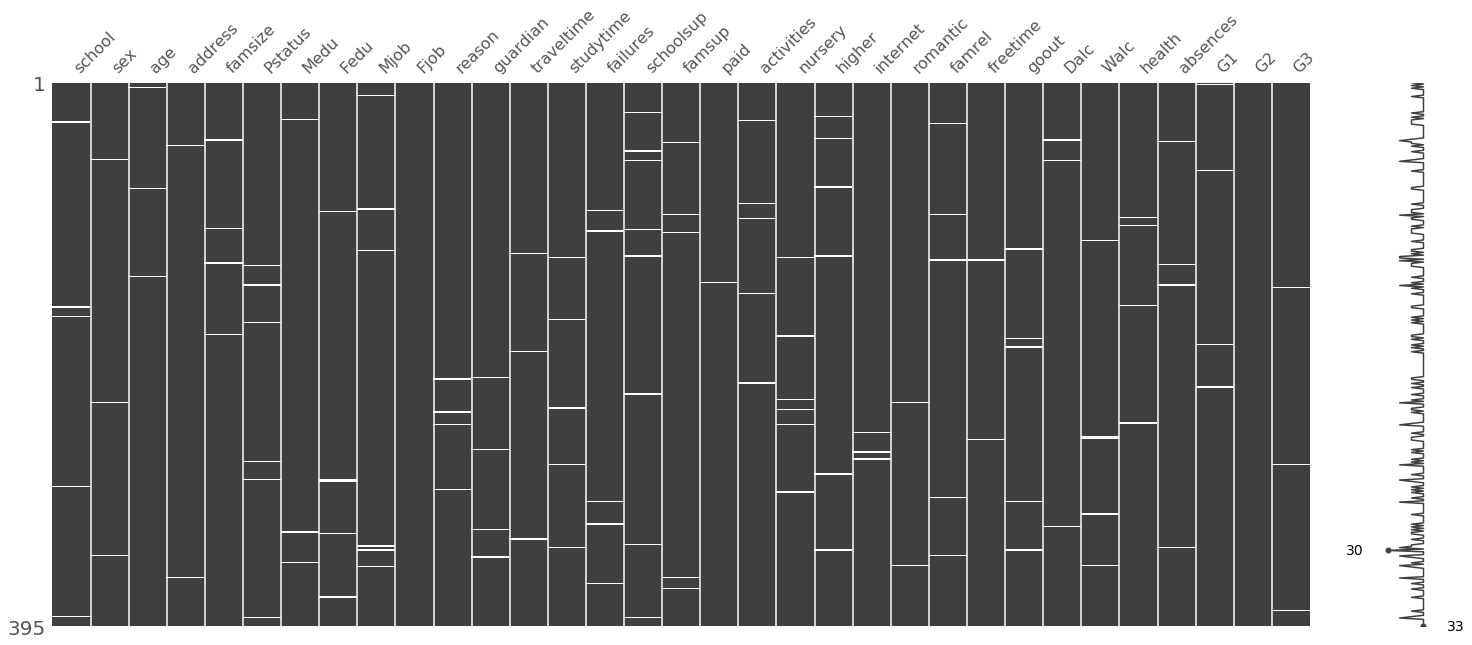

In [5]:
# Visualización datos perdidos
msngo.matrix(df)
plt.show()

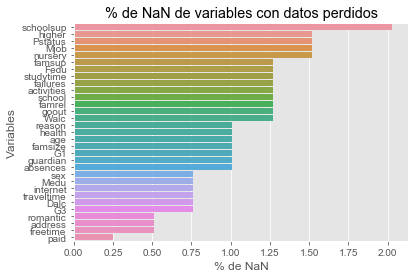

In [6]:
# Datos pérdidos por variable, en porcentajes

nan_series = (df.isna().sum()/len(df)).round(4)*100
# Ordenar valores de la serie en orden descendente
nan_series = nan_series.sort_values(ascending=False)
nan_series = nan_series[nan_series > 0]

#Creación del gráfico
plt.figure()
plt.title('% de NaN de variables con datos perdidos')
plt.style.use('seaborn')
ax = sns.barplot(x=nan_series.values, y=nan_series.index, orient='h')
plt.xlabel('% de NaN')
plt.ylabel('Variables')
plt.show()

__Comentario__: Al observar ambos gráficos nos damos cuenta de que solo 6 variables tienen datos perdidos, represntando una porción marginal de la muestra, menor al 2% de esta. Eliminar todos los datos pérdidos del DataFrame no representará un mayor coste para la muestra a utilizar para entrenar y probar el modelo.

In [7]:
# Eliminación de datos pérdidos del DataFrame
df = df.dropna()

### Exploratory Data Analysis (EDA)

#### Vector objetivo

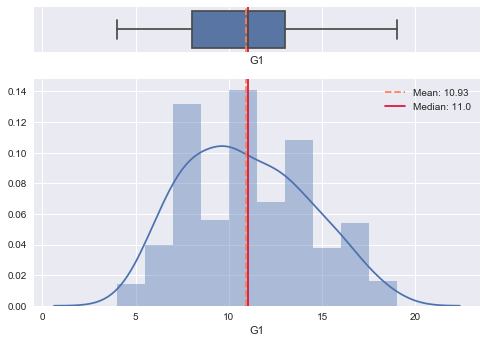

In [8]:
# Histograma c/ boxplot variable G1
fn.plot_hist(df, 'G1')

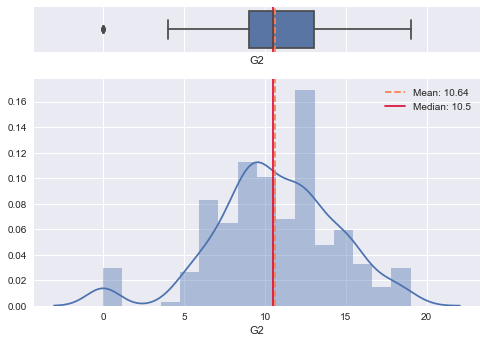

In [9]:
# Histograma c/ boxplot variable G2
fn.plot_hist(df, 'G2')

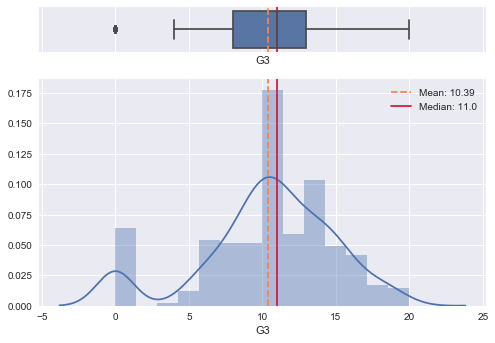

In [10]:
# Histograma c/ boxplot variable G3
fn.plot_hist(df, 'G3')

__Comentario__: Como se puede observar de los histogramas,  tanto las notas del primer y segundo semestre, en conjunto con el promedio de notas finales, siguen función de distribución bastante similar a una normal. Se puede observar que cumple bastante con la concentración de datos sobre la media, aunque presenta una anormalidad en la cola izquierda en las notas del segundo semestre (y que por lo tanto se reflejó en el promedio final), donde hubo una pequeña concnetración de notas muy bajas, seguramente entre 0 y 1.

#### Matriz de Atributos o variables independientes

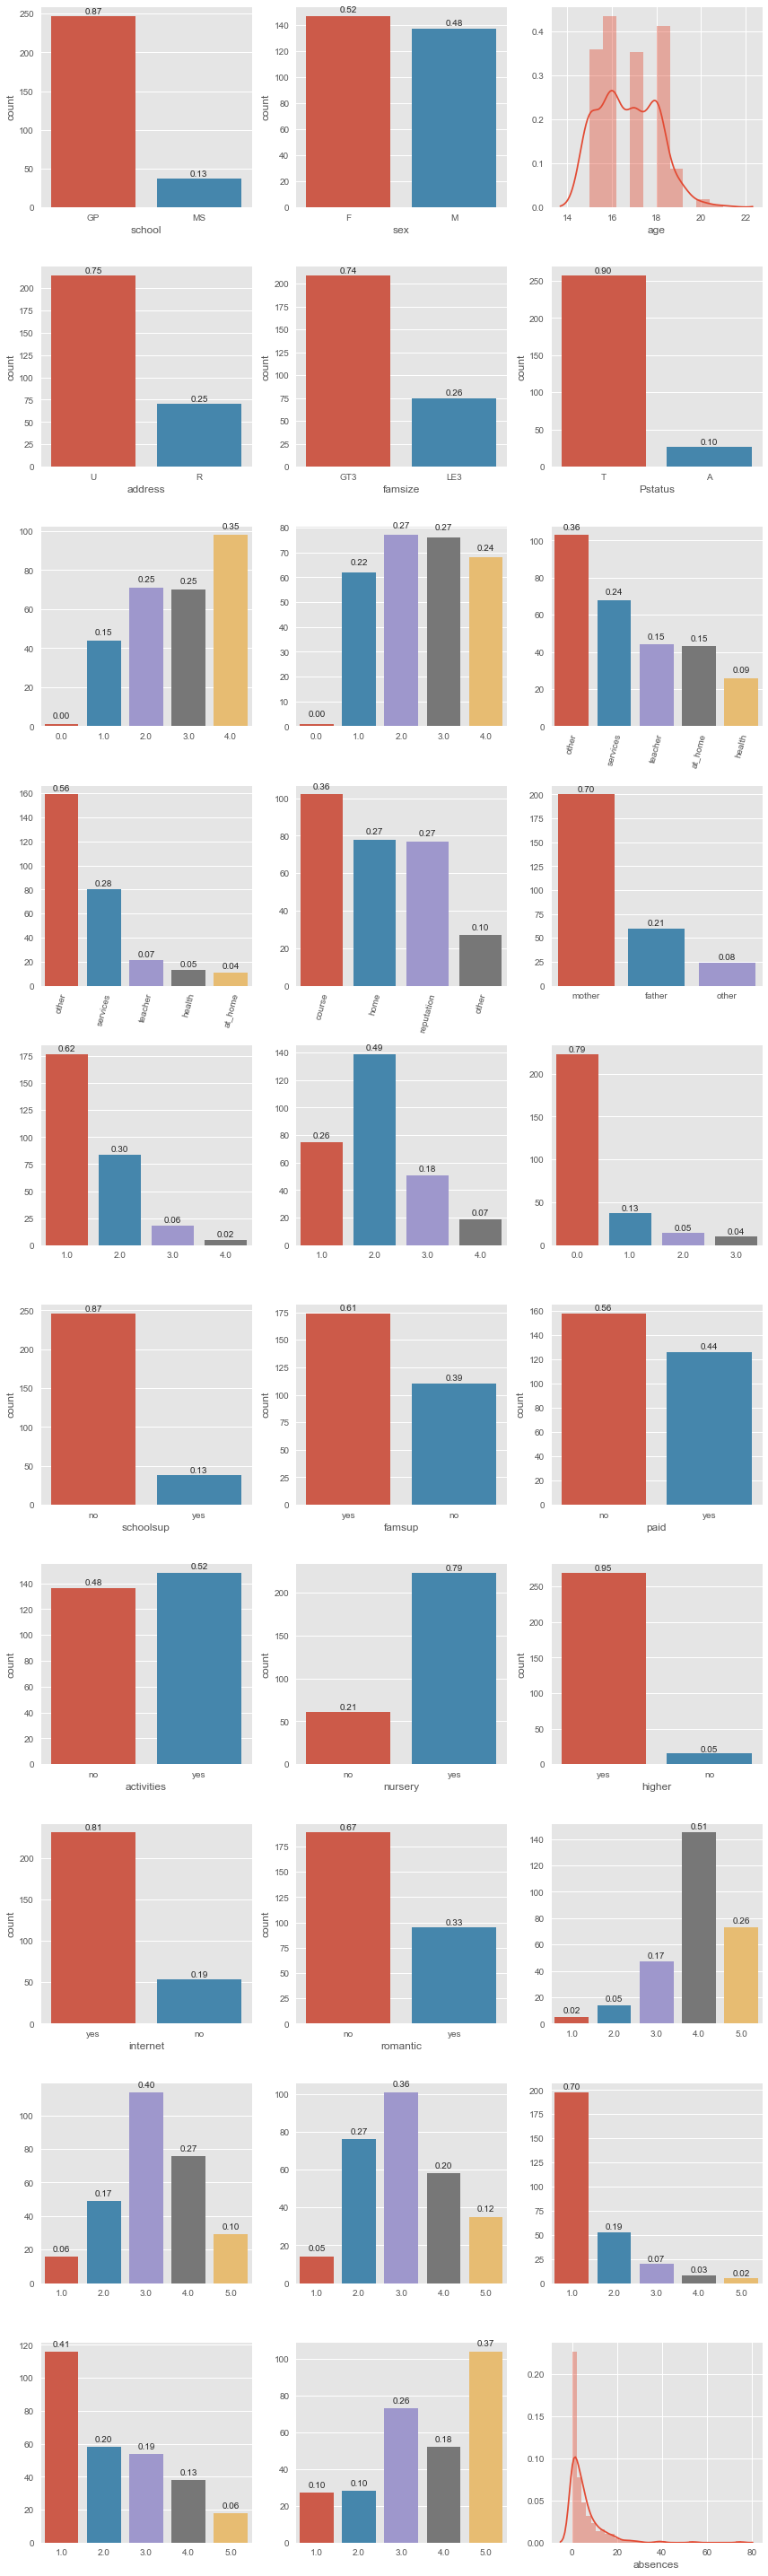

In [14]:
# Generación de gráficos para todas las variables independientes de la base
fn.univariate_plots(df.drop(['G1', 'G2', 'G3'], axis=1), 
                    categ_max=5, plots_per_row=3, fig_size=(12,40))

In [12]:
break

SyntaxError: 'break' outside loop (<ipython-input-12-6aaf1f276005>, line 4)

__Comentario__: 
* En esta muestra de estudiantes se tienen en su mayoría estudiantes del colegio Gabriel Pereira, representando cerca del 87% de esta.
* Se observa paridad de género de los estudiantes
* La edad de los estudiantes se distribuye casi de forma homogénea, entre los 15 y los 18 años.
* El 75% de los estudiantes viven en zonas urbanas.
* El 75% de las familias de los estudiantes son conformadas por más de 3 personas.
* El 90% de los estudiantes convive con sus padres.
* En el nivel educacional de los padres, se observa un heterogenea distribución tanto de padres como madres, pero con una mayor preponderancia de estudios universitarios en el caso de las madres.
* Principalmente las madres se dedican a trabajos que caen la categoría de 'otros' pero seguidas de 'servicios', salud y dueñas de hogar. 
* Entre 'otros' y 'servicios' los padres se dedican en su mayoría, como se observa en 'fjob'
* En 'reason' la principal razón de escoger la escuela fue preferencia de cursos, pero seguida no muy de lejos con cercanía del hogar y reputación de la escuela.
* Con una importante mayoría, el 70% de los estudiantes tienen a una mamá como apoderada. 'guardian'
* En 'traveltime' los estudiantes declaran que el más del 90% se demoran menos de 30 minutos para llegar al colegio.
* Los estudiantes, en promedio, dedican aproximadamente entre 2 y 5 horas a la semana, como se puede observar en 'studytime'
* En un 80% de los casos, los estudiantes no han fallado ningún ramo en 'failure'.
* Con un abrumadora mayoría, casi el 90% de los estudiantes sienten que han recibido apoyo desde el colegio.
* Un 62% de los estudiantes declara tener apoyo familiar educacional
* En 'paid' un 55% de la muestra declara tener clases particulares pagadas.
* En 'activities', la mitad de los estudiantes declara hacer actividades extracurriculares.
* Con una importante mayoría, en 'nursery' un 80% de los estudiantes declara haber asistido a guardería infantíl.
* En 'Higher' podemos ver que casi absolutamente todos los estudiantes (95%) desean proseguir estudios superiores.
* Con una importante mayoría, en 'internet' el 80% declara poseer conexión a internet desde la casa.
* En 'romantic' 1/3 de la muestra declara estar en una relación amorosa.
* En 'famrel' se observa que los alumnos consideran en una basta mayoría tener buenas relaciones con su familia, siendo en un 77% muy buenas o excelentes relaciones.
* En 'freetime' observamos que los estudiantes en promedio valoran que poseen un tiempo razonable de tiempo libre.
* Se observa en 'dalc' o consumo en día de semana que practimente una parte importante de los estudiantes no consume en estos días, siendo casos aíslados los que presentan un consumo mayor.
* En consumo de alcohol o 'walc' presenta una preponderancia a los casos con menor consumo en fines de semana, siendo un 41% los abstinentes o casi abstinentes.
* La variable 'absences' presenta una pseudo distribución normal, pero con un número de outliers de magnitudes altas que al calcular la media se captura el efecto de la cola alargada, obteniendose un valor mayor de este estadígafo al compararlo con la mediana.

## Modelación Descriptiva

### Análisis Bivariado

In [ ]:
# Análisis Bivariado con varaible dependiente 'G3': con variables independientes 
# continuas un Scatterplot, y para variables categóricas un barplot
fn.bivariate_plots(df, 'G3', categ_max=5)

__Comentario__: Al analizar las relaciones entre la varaible 'G3' y las demás variables, podemos comentar lo siguiente:

- La mediana de ambas escuelas es similar, aunque GP posee más varianza.
- Los niños y niñas tendrían unas notas similares, con una pequeña diferencia a favor de los hombres, pero estan también mayor varianza
- La edad tiene una relación inversamente negativa débil con respecto a las notas finales.
- Los niños que viven en zonas urbanas tendrían una mediana similar a sus pares de zonas rurales, pero tendrían en promedio levemente superior promedio.
- Los niños con familias de distintos tamaños poseerían notas similares, pero con una menor varianza los con familias más reducidas.
- Entre niños con padres viviendo conjuntamente o separados no hay mayor diferencia entre las distribuciones.
    

### Análisis Factorial

In [ ]:
# Creación dataframe para análisis factorial
#df_af = df.loc[:, 'famrel': 'health']

In [ ]:
# Calcular Prueba de Esfericidad de Barlett
#fact.calculate_bartlett_sphericity(df_af)

__Comentario__: Dado que el p_value del test es bastante menor que 0.05, podemos rechazar con al menos un 95% $H_0$ , que la matriz de correlaciones es similar a una matriz identidad, y por lo tanto las variables escogidas superan la primera prueba de evaluación de idoneídad para realizar el AF. 

In [ ]:
# Cálculos de KMOs
#KMOs = fact.calculate_kmo(df_af)[0]
#var_list = list(df_af.columns)

#print('KMO Total', KMOs[1])
#pd.DataFrame({'KMO': KMOs}, index=var_list)

__Comentario__: Cómo los valores de KMO de las variables analizadas son todas menores a 0.7, se recomienda no efectuar el análisis factorial.

### Binarización de variables

In [ ]:
df = fn.binarize(df)
df.columns

__Comentario__: Se binarizan las variables categóricas del df, dejando siempre n-1 nuevas columnas, con n = número de categorías.

### Correlaciones lineales y Heatmap

In [ ]:
fn.heatmap(df, fig_size=(25,25))

### Modelación Regresión lineal multiple

In [ ]:
# Creación de matriz de atributos y vector objetivo
X_mat = df.drop(columns=['G3', 'G2', 'G1'])
y_vec = df['G3']

# Regresión multiple lineal con todas los atributos
sm_ols = sm.OLS(y_vec,X_mat).fit()
sm_ols.summary()

In [ ]:
# Se aplica función que itera la regresión lineal y remueve atributos con p values 
# con coeficientes p value mayores a 0.05
X_mat2 = fn.ols_feature_rm(X_mat, y_vec, add_constant=True, p_value_max=.05)
# Se revisa cuantos atributos quedaron
len(X_mat2.columns)

In [ ]:
# Regresión multiple lineal con atributos seleccionados
sm_ols = sm.OLS(y_vec, sm.add_constant(X_mat2)).fit()
sm_ols.summary()

__Comentario__: Como se puede observar, las variables que fueron relevantes para el modelo estan relacionadas al nivel educacional de la madre, si la ocupación de la madre es profresora o no, el número de clases reprobadas, al tiempo libre fuera del colegio, a la cantidad de salidas con amigos, y si su estado de salud es muy malo.

In [ ]:
# Heatmap atributos seleccionados
fn.heatmap(X_mat2, fig_size=(16,8))

__Comentario__: Como ninguna variable predictiva está fuertemente correlacionada (al menos > 0.7), se opta por continuar con todas estas variables a la modelación predictiva.

## Modelación Predictiva

### 1º Modelo: Sin estandarización, 33% de la muestra para la prueba

In [ ]:
# Separación de la muestra de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_mat2, y_vec, test_size=.33, 
                                                    random_state=12345)

In [ ]:
# Fit del modelo
ols_1 = LinearRegression(normalize=False, fit_intercept=True).fit(X_train, y_train)
# Vector predecido
y_hat_1 = ols_1.predict(X_test)
# Métricas
mse = mean_squared_error(y_test, y_hat_1).round(3)
r2 = r2_score(y_test, y_hat_1).round(3)
    
print('El error cuadrático medio es',mse,'\nEl R cuadrado es',r2)

### 2º Modelo: Con estandarización, 33% de la muestra para la prueba

In [ ]:
# Fit del modelo
ols_2 = LinearRegression(normalize=False, fit_intercept=False).fit(X_train, y_train)
# Vector predecido
y_hat_2 = ols_2.predict(X_test)
# Métricas
mse = mean_squared_error(y_test, y_hat_1).round(3)
r2 = r2_score(y_test, y_hat_1).round(3)
    
print('El error cuadrático medio es',mse,'\nEl R cuadrado es',r2)

__Comentario__: Al realizar estandarización de las variables no genera ningún cambio en las métricas. Esto se explica dado que todas los atributos del modelos son variables binarias (1/0)

### Selección de modelos: Cross Validation

In [ ]:
%%time
# Estandarización de variables
std_mat = StandardScaler().fit_transform(X_mat2)
# Tranformación Polinomial para interacciones de orden 2 y 3
or2_mat = PolynomialFeatures(degree=2, interaction_only=True, 
                              include_bias=False).fit_transform(std_mat)
or3_mat = PolynomialFeatures(degree=3, interaction_only=True, 
                              include_bias=False).fit_transform(std_mat)
or4_mat = PolynomialFeatures(degree=4, interaction_only=True, 
                              include_bias=False).fit_transform(std_mat)
# Lista con métricas a evaluar
eval_metrics = ['neg_mean_squared_error', 'r2']

# Validación cruzada y cálculo de métricas
for index, value in enumerate(eval_metrics):
    tmp_1 = cross_val_score(LinearRegression(), std_mat, y_vec, cv=10, scoring=value)
    tmp_2 = cross_val_score(LinearRegression(), or2_mat, y_vec, cv=10, scoring=value)
    tmp_3 = cross_val_score(LinearRegression(), or3_mat, y_vec, cv=10, scoring=value)
    tmp_4 = cross_val_score(LinearRegression(), or4_mat, y_vec, cv=10, scoring=value)
    tmp = pd.DataFrame({'Aditivo': tmp_1, 'Interacción orden-2': tmp_2,
                        'Interacción orden-3': tmp_3, 'Interacción orden-4': tmp_4}
                      ).unstack().reset_index()
    tmp.rename(columns={'level_0': 'order', 'level_1': 'num', '0': 'score'}, 
               inplace=True)
    # Graficar métricas por modelos
    plt.subplot(1, 2, index + 1)
    sns.boxplot(tmp.iloc[:, 0], tmp.iloc[:, 2])
    plt.title(value.capitalize())
    plt.ylabel(' ')
    plt.xlabel(' ')
    plt.xticks(rotation=45, ha='right')
    
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (14, 6)

__Comentario__: Cómo se puede observar de los experimentos con diferentes grados de transformación polinomial de la matriz de atributos, tanto el error cuadrático medio como el $R^2$ empeoran considerablemente en sus valores, por lo que se descarta la utilización de transfomración polinomial para el modelo predictivo, y se prefiere por quedarse con el modelo orginal aditivo para generar mejores predicciones.